In [194]:
import matplotlib.pyplot as plt
# Standard data science libs
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


wine_data_all = pd.read_csv("winequality-all.csv")
# Clean the data
# Identify and remove outliers for each numeric column except "colour"
numeric_columns = wine_data_all.select_dtypes(include=['number']).columns
outliers_removed_data = wine_data_all.copy()

for column in numeric_columns:
    if column != 'colour':
        # Calculate interquartile range
        q25, q75 = wine_data_all[column].quantile(0.25), wine_data_all[column].quantile(0.75)
        iqr = q75 - q25

        # Calculate the outlier cutoff
        cut_off = iqr * 2.5
        lower, upper = q25 - cut_off, q75 + cut_off

        # Identify outliers
        outliers = wine_data_all[(wine_data_all[column] < lower) | (wine_data_all[column] > upper)]

        # Remove outliers
        outliers_removed_data = outliers_removed_data[(outliers_removed_data[column] >= lower) & (outliers_removed_data[column] <= upper)]
# Output csv without quality column
outliers_removed_data.drop(columns="quality").to_csv("wine_data_outliers_removed.csv", index=False)
outliers_removed_data.to_csv("wine_data_outliers_removed_with_quality_col.csv")

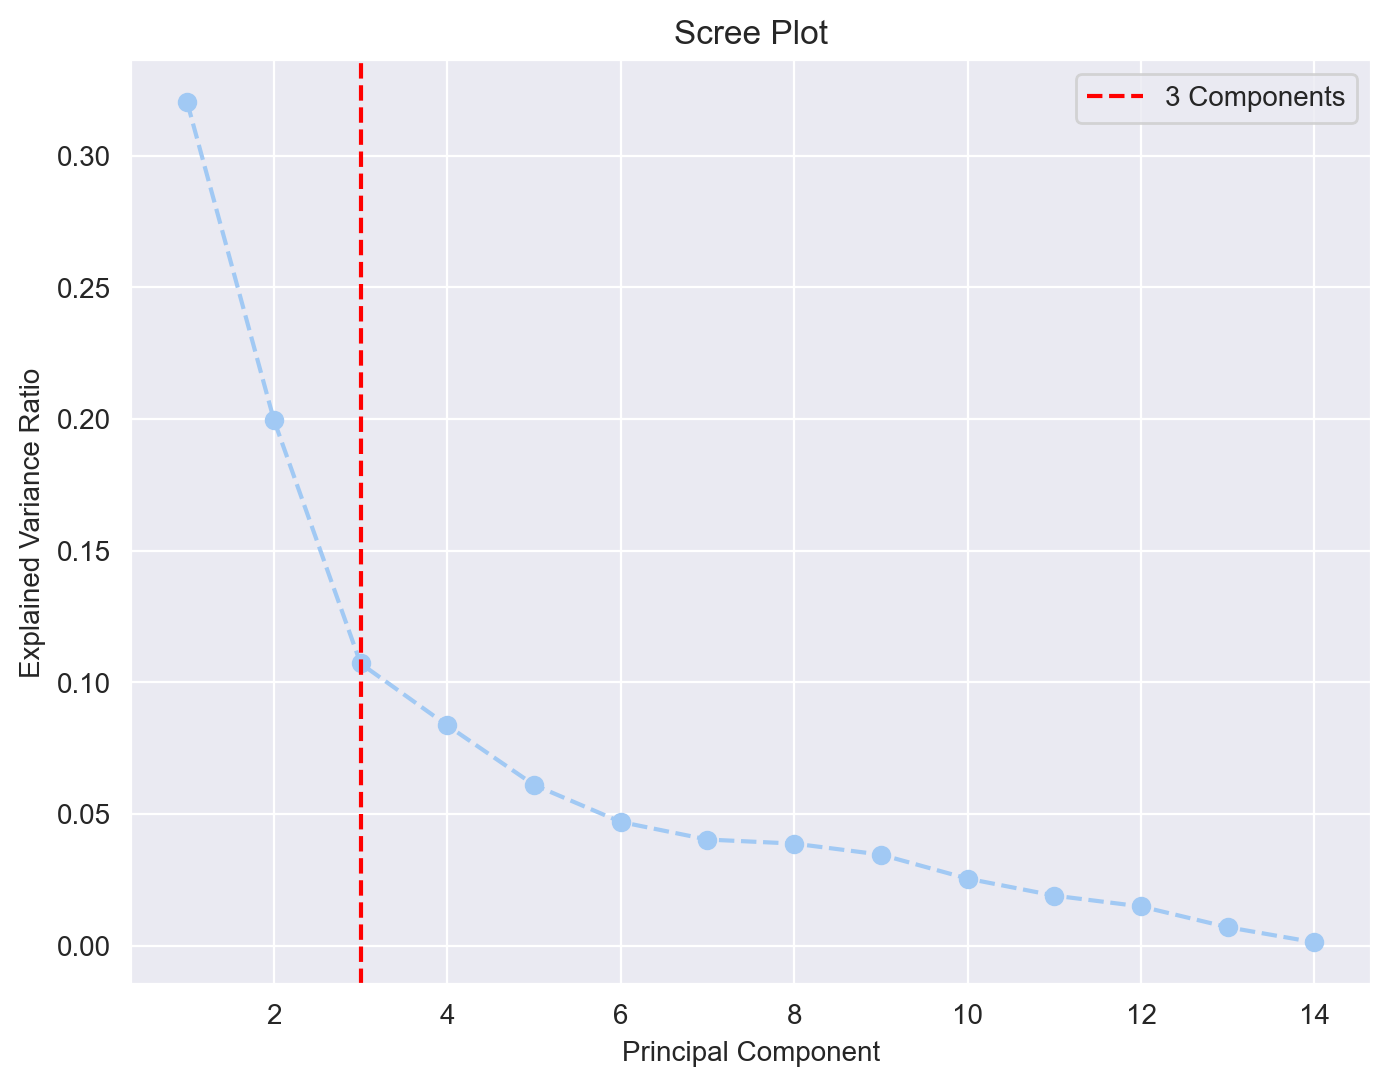

In [195]:
# Produce a Scree plot
outliers_removed_with_quality_col = pd.read_csv("wine_data_outliers_removed_with_quality_col.csv")
pca = PCA()
scalar = StandardScaler()
pipeline = make_pipeline(scalar,pca)
fit_with_quality_col = pipeline.fit(outliers_removed_with_quality_col)
explained_variance = pca.explained_variance_ratio_
# Create the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

# Add a vertical line at the point where the elbow is
num_components_desired = 3
plt.axvline(x=num_components_desired, color='r', linestyle='--', label=f'{num_components_desired} Components')

plt.legend()  # Add legend for the red line


loadings = pca.components_.T

# Create a DataFrame with labeled columns
num_components = loadings.shape[1]  # Number of PCA components

# Create a DataFrame with columns labeled as "PCA 1," "PCA 2," ...
pca_columns = [f'PCA {i + 1}' for i in range(num_components)]
pca_df = pd.DataFrame(loadings, columns=pca_columns)
plt.savefig("Scree_plot_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List
%config InlineBackend.figure_format = 'retina'
plt.style.use('fast')
sns.set_palette("pastel")
'''
A function to produce biplots for PCA components. Produces plots side by side. Make sure you import all dependencies before running function. If should_last_term_label_have_new_line is True, the labels present for each eigenvalue E.g. Total sulfur dioxide will be displayed as
Total sulfur
dixoide
rather than
Total sulfur dioxide
'''
def biplot_for_pca(data: pd.DataFrame, pipeline_fit: object, pca_fit: PCA ,pca_number_for_x_axis: int, pca_number_for_y_axis: int, plot_titles: List[str], figure_file_name: str, should_last_term_label_have_new_line = False) -> None:
    # Set up the initial plot structure
    fig, ax = plt.subplots(figsize=(16, 6), ncols=2)
    ax[0].grid(True)
    ax[1].grid(True)
    # Produce a single plot for each PC number - axis_index is the index of the pca_number
    for axis_index, pca_number in enumerate([pca_number_for_x_axis,pca_number_for_y_axis]):
        pca_data_index_x = pca_number - 1
        pca_data_index_y = pca_number
        ax[axis_index].axis("equal")
        ax[axis_index].set_xlim(-1, 1)
        ax[axis_index].set_ylim(-1, 1)
        ax[axis_index].set_xlabel(f"PC{pca_number}")
        ax[axis_index].set_ylabel(f"PC{pca_number + 1}")
        ax[axis_index].set_title(plot_titles[pca_data_index_x], fontsize=16, y=1.1)
         # Extract transformed values from fit for x and y axes
        pca_data_index_x = pca_number - 1
        pca_data_index_y = pca_number

        pca_data_x = pipeline_fit.transform(data)[:, pca_data_index_x]
        pca_data_y = pipeline_fit.transform(data)[:, pca_data_index_y]
        coeff = np.transpose(pca_fit.components_[pca_data_index_x:pca_data_index_y + 1, :])
        n = data.shape[1]
        scale_x_axis = 1.0 / (pca_data_x.max() - pca_data_x.min())
        scale_y_axis = 1.0 / (pca_data_y.max() - pca_data_y.min())

        # Used for differentiating the wine type
        sns.scatterplot(x=pca_data_x * scale_x_axis, y=pca_data_y * scale_y_axis,
                        hue=data['colour'], alpha=0.5, ax=ax[pca_data_index_x])
        
        # Generate the legend
        legend = ax[axis_index].legend(title='Wine colour', loc='upper right')
        legend.get_texts()[0].set_text("White wine")
        legend.get_texts()[1].set_text("Red wine")

        # Modify labels so they don't overlap too much - helps readability
        for column_index in range(n):
            x_position = coeff[column_index, 0]
            y_position = coeff[column_index, 1]

            # Check if the label will overlap with others, and adjust position if needed
            if column_index < n - 1:
                for j in range(column_index + 1, n):
                    if (abs(x_position - coeff[j, 0]) < 0.1) and (abs(y_position - coeff[j, 1]) < 0.1):
                        x_position += 0.1
                        y_position += 0.1
            label = data.T.index[column_index]
            
            if should_last_term_label_have_new_line:
                # Find the last space character and replace it with a newline
                last_space_index = label.rfind(" ")
                if last_space_index >= 0:
                    # Add an extra new line for total sulfur dioxide so labels don't overlap
                    if pca_data_index_y == 4 and column_index == 6:
                        label = label[:last_space_index] + "\n\n" + label[last_space_index + 1:]
                    label = label[:last_space_index] + "\n" + label[last_space_index + 1:]
            
            ax[pca_data_index_x].arrow(0, 0, x_position, y_position, color="r")
            # Add arrowheads to labels
            ax[pca_data_index_x].annotate(label, (x_position, y_position), color="black",
                                    arrowprops=dict(arrowstyle="->", lw=1.5),
                                    fontsize=8, ha='center', va='center')
        # Add a line for x and y axes
        ax[pca_data_index_x].axhline(0, color='black', linewidth=0.5)
        ax[pca_data_index_x].axvline(0, color='black', linewidth=0.5)  
    fig.savefig(figure_file_name, dpi=300, bbox_inches='tight')

In [196]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
def fit_pca_and_apply_plots(csv_file_name: str, n_components_for_pca: int, file_name:str):
    read_data = pd.read_csv(csv_file_name)
    scalar = StandardScaler()
    pca = PCA(n_components=n_components_for_pca)
    pipeline = make_pipeline(scalar,pca)
    pipeline_fit = pipeline.fit(read_data)
    explained_variance = ["{:.2%}".format(num) for num in pca.explained_variance_ratio_]
    plot_title_list = []
    for pca_number in range(1,n_components_for_pca-1):
        plot_title_list.append( f"Plot of PC{pca_number + 1} ({explained_variance[pca_number]} explained variance)\n against PC{pca_number} ({explained_variance[pca_number - 1]} explained variance)")
        plot_title_list.append(f"Plot of PC{pca_number + 2} ({explained_variance[pca_number + 1]} explained variance)\n against PC{pca_number+1} ({explained_variance[pca_number]} explained variance)")
        biplot_for_pca(data=read_data,pipeline_fit=pipeline_fit,pca_fit=pca,pca_number_for_x_axis=pca_number,pca_number_for_y_axis=pca_number+1,plot_titles=plot_title_list,figure_file_name=file_name)

In [197]:
def biplot_for_pca_quality(data:pd.DataFrame,pipeline_fit: object, pca_fit: PCA, pca_number_for_x_axis: int, pca_number_for_y_axis: int, plot_title: str, figure_file_name: str) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create subplots with 1 row and 2 columns
    axes = axes.flatten()  # Flatten the 2D array of axes

    for ax, pca_number in zip(axes, range(1, 3)):
        ax.grid(True)
        ax.axis("equal")
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xlabel(f"PC{pca_number}")
        ax.set_ylabel(f"PC{pca_number + 1}")
        ax.set_title(f"Plot of PC{pca_number + 1} against PC{pca_number}", fontsize=16, y=1.1)

        # Create a new column based on conditions
        data_copy = data.copy()
        conditions = [
            (data_copy['quality'].ge(3) & data_copy['quality'].lt(6)),
            (data_copy['quality']).eq(6),
            (data_copy['quality'].ge(7) & data_copy['quality'].le(9)),
        ]

        # Define corresponding categories
        categories = ['3-5','6', '7-9']
        # Use np.select to assign categories based on conditions
        data_copy['quality_category'] = np.select(conditions, categories, default='Unknown')
        
        # Create a mapping for color and quality category combinations
        category_mapping = {
            (0, '3-5'): '3-5 white',
            (0, '6'): '6 white',
            (0, '7-9'): '7-9 white',
            (1, '3-5'): '3-5 red',
            (1, '6'): '6 red',
            (1, '7-9'): '7-9 red',
        }
        
        legend_labels = [
    '3-5 (White)',
    '6 (White)',
    '7-9 (White)',
    '3-5 (Red)',
    '6 (Red)',
    '7-9 (Red)'
]
        # Apply the mapping to create the 'quality_categories_by_wine' column
        data_copy['quality_categories_by_wine'] = data_copy[['colour', 'quality_category']].apply(tuple, axis=1).map(category_mapping)

        # Drop unnecessary columns
        data_copy = data_copy.drop(columns=['quality_category'])

        # Define the features to be scaled (excluding 'quality_categories_by_wine')
        features_to_scale = [col for col in data_copy.columns if col != 'quality_categories_by_wine']

        # Create a ColumnTransformer that applies StandardScaler to specified features
        preprocessor = ColumnTransformer(
            transformers=[
                ('scaler', StandardScaler(), features_to_scale),
            ],
            remainder='passthrough'  # Pass through columns not specified in transformers
        )

        pca_new = PCA(n_components=3)

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('pca', pca_new)
        ])

        # Exclude 'quality_categories_by_wine' during fitting
        pipeline.fit(data_copy.drop(columns=['quality_categories_by_wine']))

        transformed_data = pipeline.transform(data_copy.drop(columns=['quality_categories_by_wine']))

        # Extract transformed values from fit for x and y axes
        pca_data_index_x = pca_number - 1
        pca_data_index_y = pca_number + 1 - 1
        pca_data_x = transformed_data[:, pca_data_index_x]
        pca_data_y = transformed_data[:, pca_data_index_y]
        # Extract the components from the pipeline
        components = pipeline.named_steps['pca'].components_
        # Check if index is within bounds
        if pca_data_index_y >= components.shape[0]:  
            continue

        coeff = np.transpose(components[pca_data_index_x:pca_data_index_y + 1, :])
        n = data_copy.shape[1]
        scale_x_axis = 1.0 / (pca_data_x.max() - pca_data_x.min())
        scale_y_axis = 1.0 / (pca_data_y.max() - pca_data_y.min())
        # Your existing scatter plot code
        scatter = sns.scatterplot(x=pca_data_x * scale_x_axis, y=pca_data_y * scale_y_axis, hue=data_copy['quality_categories_by_wine'], alpha=0.8, ax=ax)



        ax.legend(title='Quality Categories', loc='upper right')

        for column_index in range(min(n, len(coeff))):
            x_position = coeff[column_index, 0]
            y_position = coeff[column_index, 1]

            # Check if the label will overlap with others, and adjust position if needed
            if column_index < n - 1:
                for j in range(column_index + 1, min(n, len(coeff))):
                    if (abs(x_position - coeff[j, 0]) < 0.1) and (abs(y_position - coeff[j, 1]) < 0.1):
                        x_position += 0.1
                        y_position += 0.1

            label = data_copy.T.index[column_index]

            # Find the last space character and replace it with a newline
            last_space_index = label.rfind(" ")
            if last_space_index >= 0:
                # Add an extra new line for total sulfur dioxide so labels don't overlap
                if pca_data_index_y == 4 and column_index == 6:
                    label = label[:last_space_index] + "\n\n" + label[last_space_index + 1:]
                label = label[:last_space_index] + "\n" + label[last_space_index + 1:]

            ax.arrow(0, 0, x_position, y_position, color="r")
            # Add arrowheads to labels
            ax.annotate(label, (x_position, y_position), color="black",
                         arrowprops=dict(arrowstyle="->", lw=1.5),
                         fontsize=8, ha='center', va='center')

        ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line
        ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line

    fig.savefig(figure_file_name, dpi=300, bbox_inches='tight')

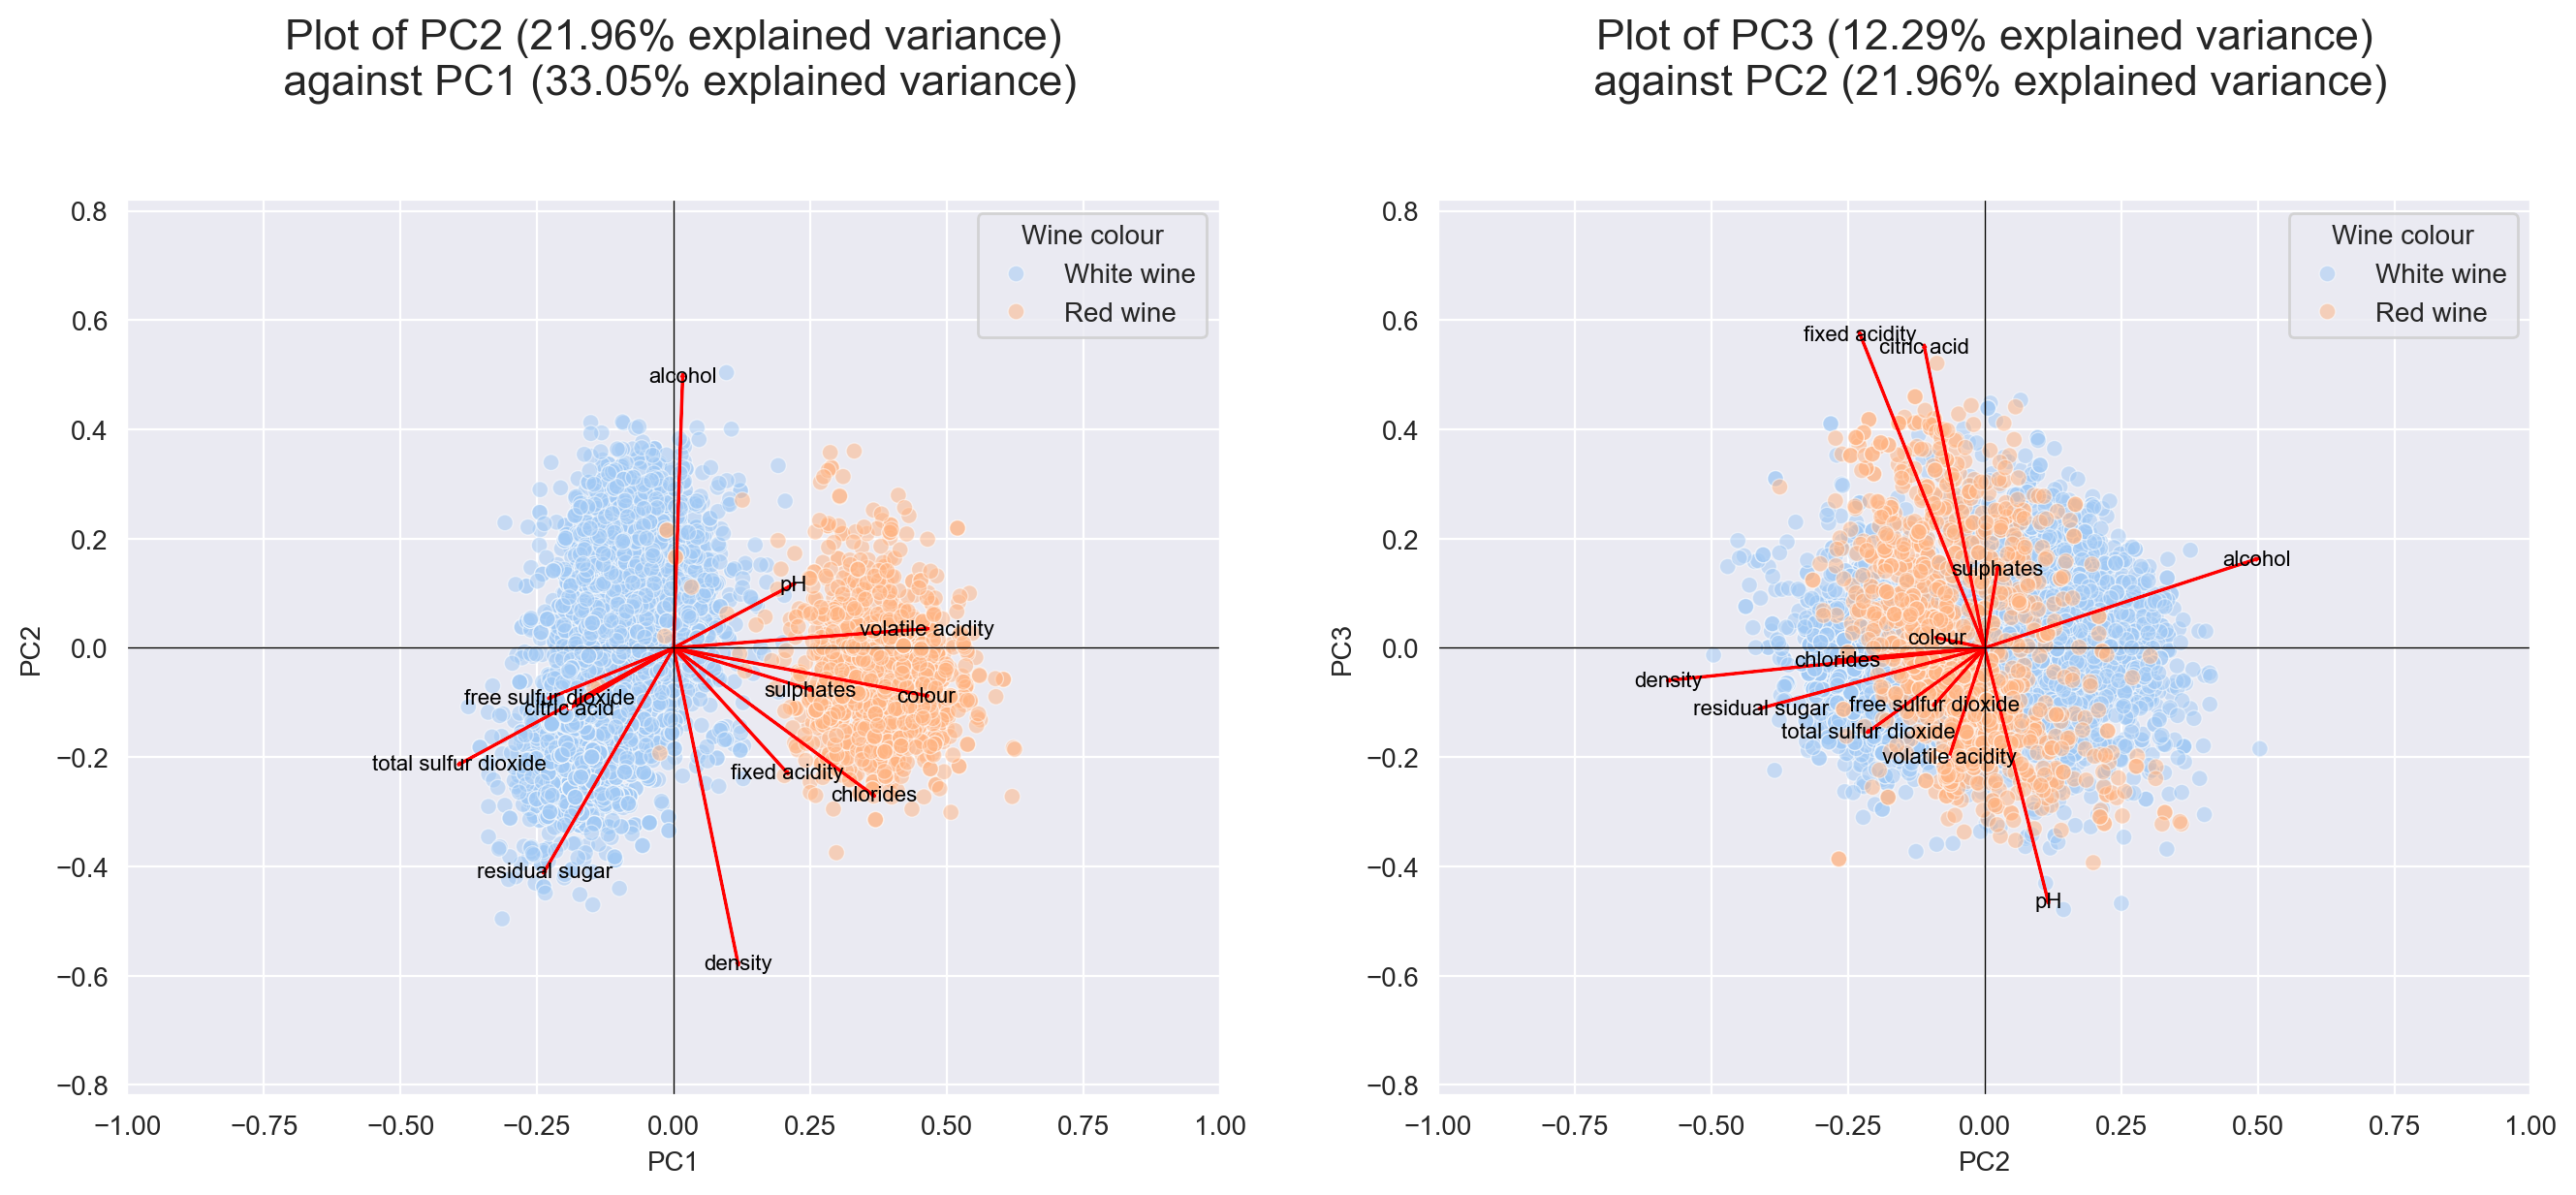

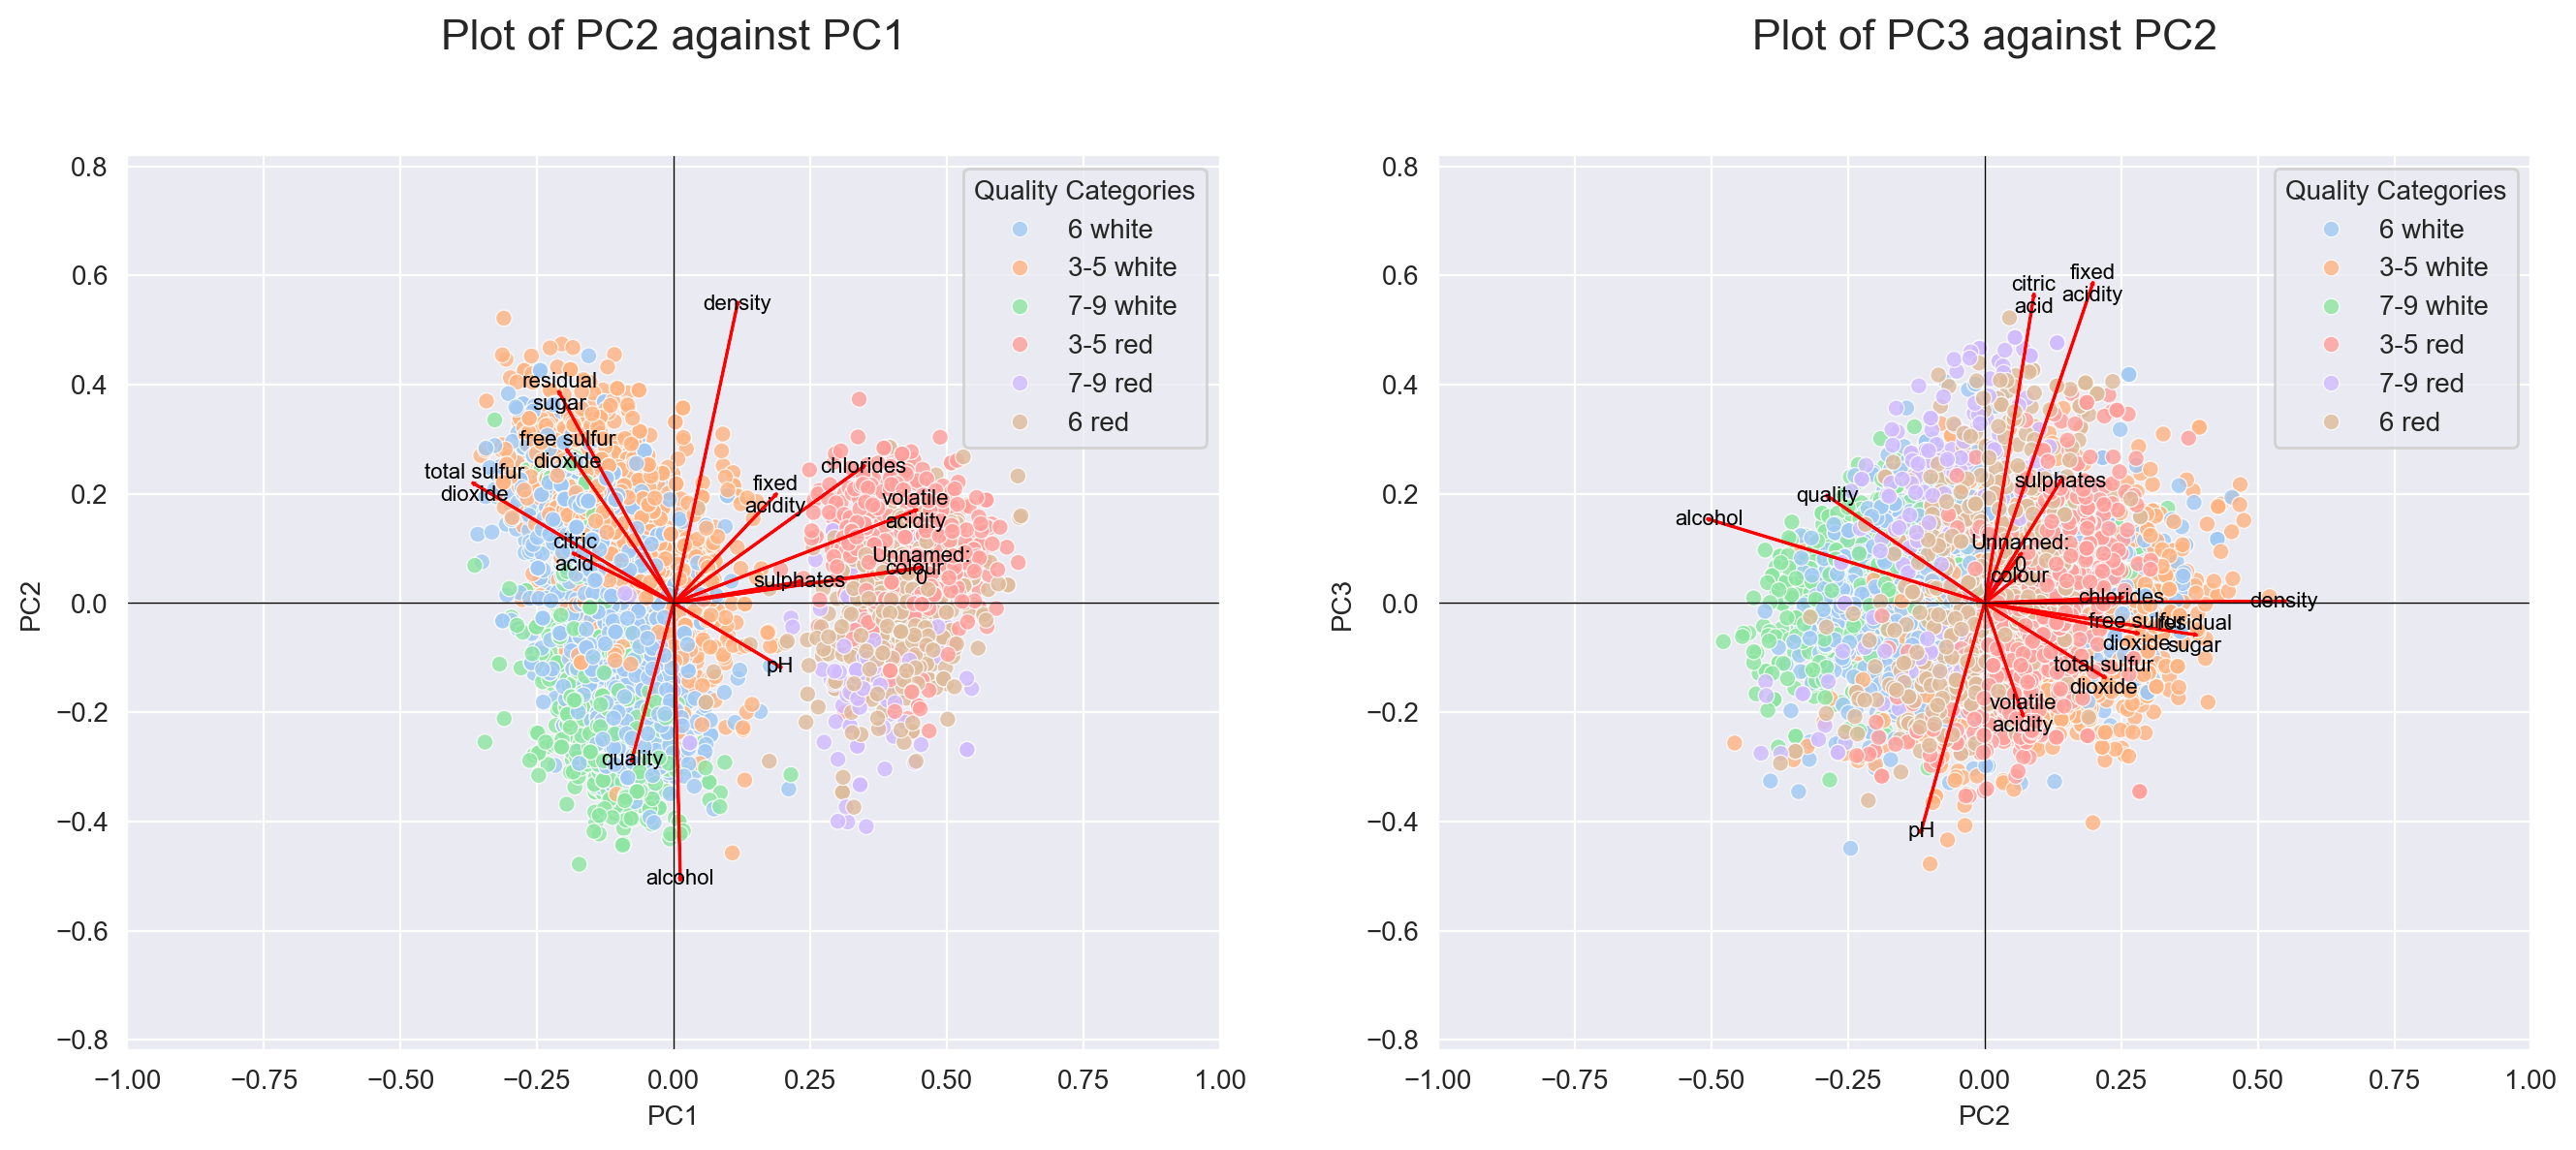

In [198]:
# Produce plots for data with no quality column
fit_pca_and_apply_plots("wine_data_outliers_removed.csv",3,"biplots_no_quality_final.png")
# Produce plots for data with quality column

for pca_number in range(1, 2):
    # Create a new PCA object for each plot
    pca_quality_col = PCA(n_components=3)
    # Call the function with the specific PCA object
    biplot_for_pca_quality(outliers_removed_with_quality_col,fit_with_quality_col, pca_quality_col, pca_number, pca_number + 1,
                           f"Plot of PC{pca_number + 1} against PC{pca_number}",
                          "biplots_quality_final.png")



In [199]:
from statsmodels.multivariate.manova import MANOVA
formula = 'Q("volatile acidity") + Q("fixed acidity") + Q("pH") ~ colour'
manova_model = MANOVA.from_formula(formula, data=outliers_removed_data)
print(manova_model.mv_test(skip_intercept_test=True))

                   Multivariate linear model
                                                                
----------------------------------------------------------------
         colour         Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.3795 3.0000 6040.0000 3292.1193 0.0000
         Pillai's trace 0.6205 3.0000 6040.0000 3292.1193 0.0000
 Hotelling-Lawley trace 1.6352 3.0000 6040.0000 3292.1193 0.0000
    Roy's greatest root 1.6352 3.0000 6040.0000 3292.1193 0.0000


In [200]:
from typing import Union
from scipy.stats import f
'''
A function that calculates CIs for hotelling t-test for a given sig level. For two populations, supply the dataframe to group_2.
'''
def hotelling_t_test_ci(group_1:pd.DataFrame, group_2 = Union[pd.DataFrame, None], sig_level=0.05) -> dict:
    # Calculate group sizes
    group_1_n = group_1.shape[0]
    # Can use either group 1 or 2 as they have equal number of variables
    number_of_dependent_variables = group_1.shape[1]
    # Calculate means for each variable for each group
    group_1_means = group_1.mean()
    # Degrees of freedom for F statistic
    df1 = number_of_dependent_variables
    df2 = group_1_n - df1
    group_1_cov = group_1.cov()
    if group_2 is not None:
        group_2_n = group_2.shape[0]
        group_2_means = group_2.mean()
        total_n = group_1_n + group_2_n
        df2 = total_n - number_of_dependent_variables - 1
        covariance_matrix = ((group_1_n - 1)*group_1_cov+(group_2_n-1)*group_2.cov())/(group_1_n+group_2_n-2)
        group_mean_diff = group_1_means - group_2_means
        f_critical = f.ppf(1 - sig_level, df1, df2)
        # K = sqrt((np-p)/(n(n-p)) * F_crit_df1_df2_0.95 )
        k_value = np.sqrt((total_n*df1-df1)/total_n*(total_n-df1) * f_critical)
        std_err = np.sqrt(np.diag(covariance_matrix))*k_value
        # Construct the dictionary
        result = {col: (mean, std_err[i]) for i, (col, mean) in enumerate(group_mean_diff.items())}

        return result
    f_critical = f.ppf(1 - sig_level, df1, df2)
    k_value = np.sqrt((group_1_n*df1-df1)/group_1_n*(group_1_n-df1) * f_critical)
    std_err = np.sqrt(np.diag(group_1.cov()))*k_value
    # Construct the dictionary
    result = {col: (mean, std_err[i]) for i, (col, mean) in enumerate(group_1_means.items())}

    return result


In [201]:
def display_cis(hotelling_ci_func: dict) -> None:
    for key, value in hotelling_ci_func.items():
        lower_bound = "{:.2f}".format(value[0]-value[1])
        upper_bound = "{:.2f}".format(value[0]+value[1])
        print(f"{key} ({lower_bound}, {upper_bound})")
red_acidity = wine_data_all[["volatile acidity","fixed acidity","pH"]].loc[wine_data_all["colour"] == 1]
white_acidity = wine_data_all[["volatile acidity","fixed acidity","pH"]].loc[wine_data_all["colour"] == 0]
display_cis(hotelling_ci_func=hotelling_t_test_ci(red_acidity,white_acidity))

volatile acidity (-27.85, 28.35)
fixed acidity (-253.73, 256.65)
pH (-34.09, 34.34)


C:\Users\kayvo\AppData\Local\Temp\ipykernel_35416\1973003499.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['White Wine', 'Red Wine'])
C:\Users\kayvo\AppData\Local\Temp\ipykernel_35416\1973003499.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['White Wine', 'Red Wine'])
C:\Users\kayvo\AppData\Local\Temp\ipykernel_35416\1973003499.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['White Wine', 'Red Wine'])


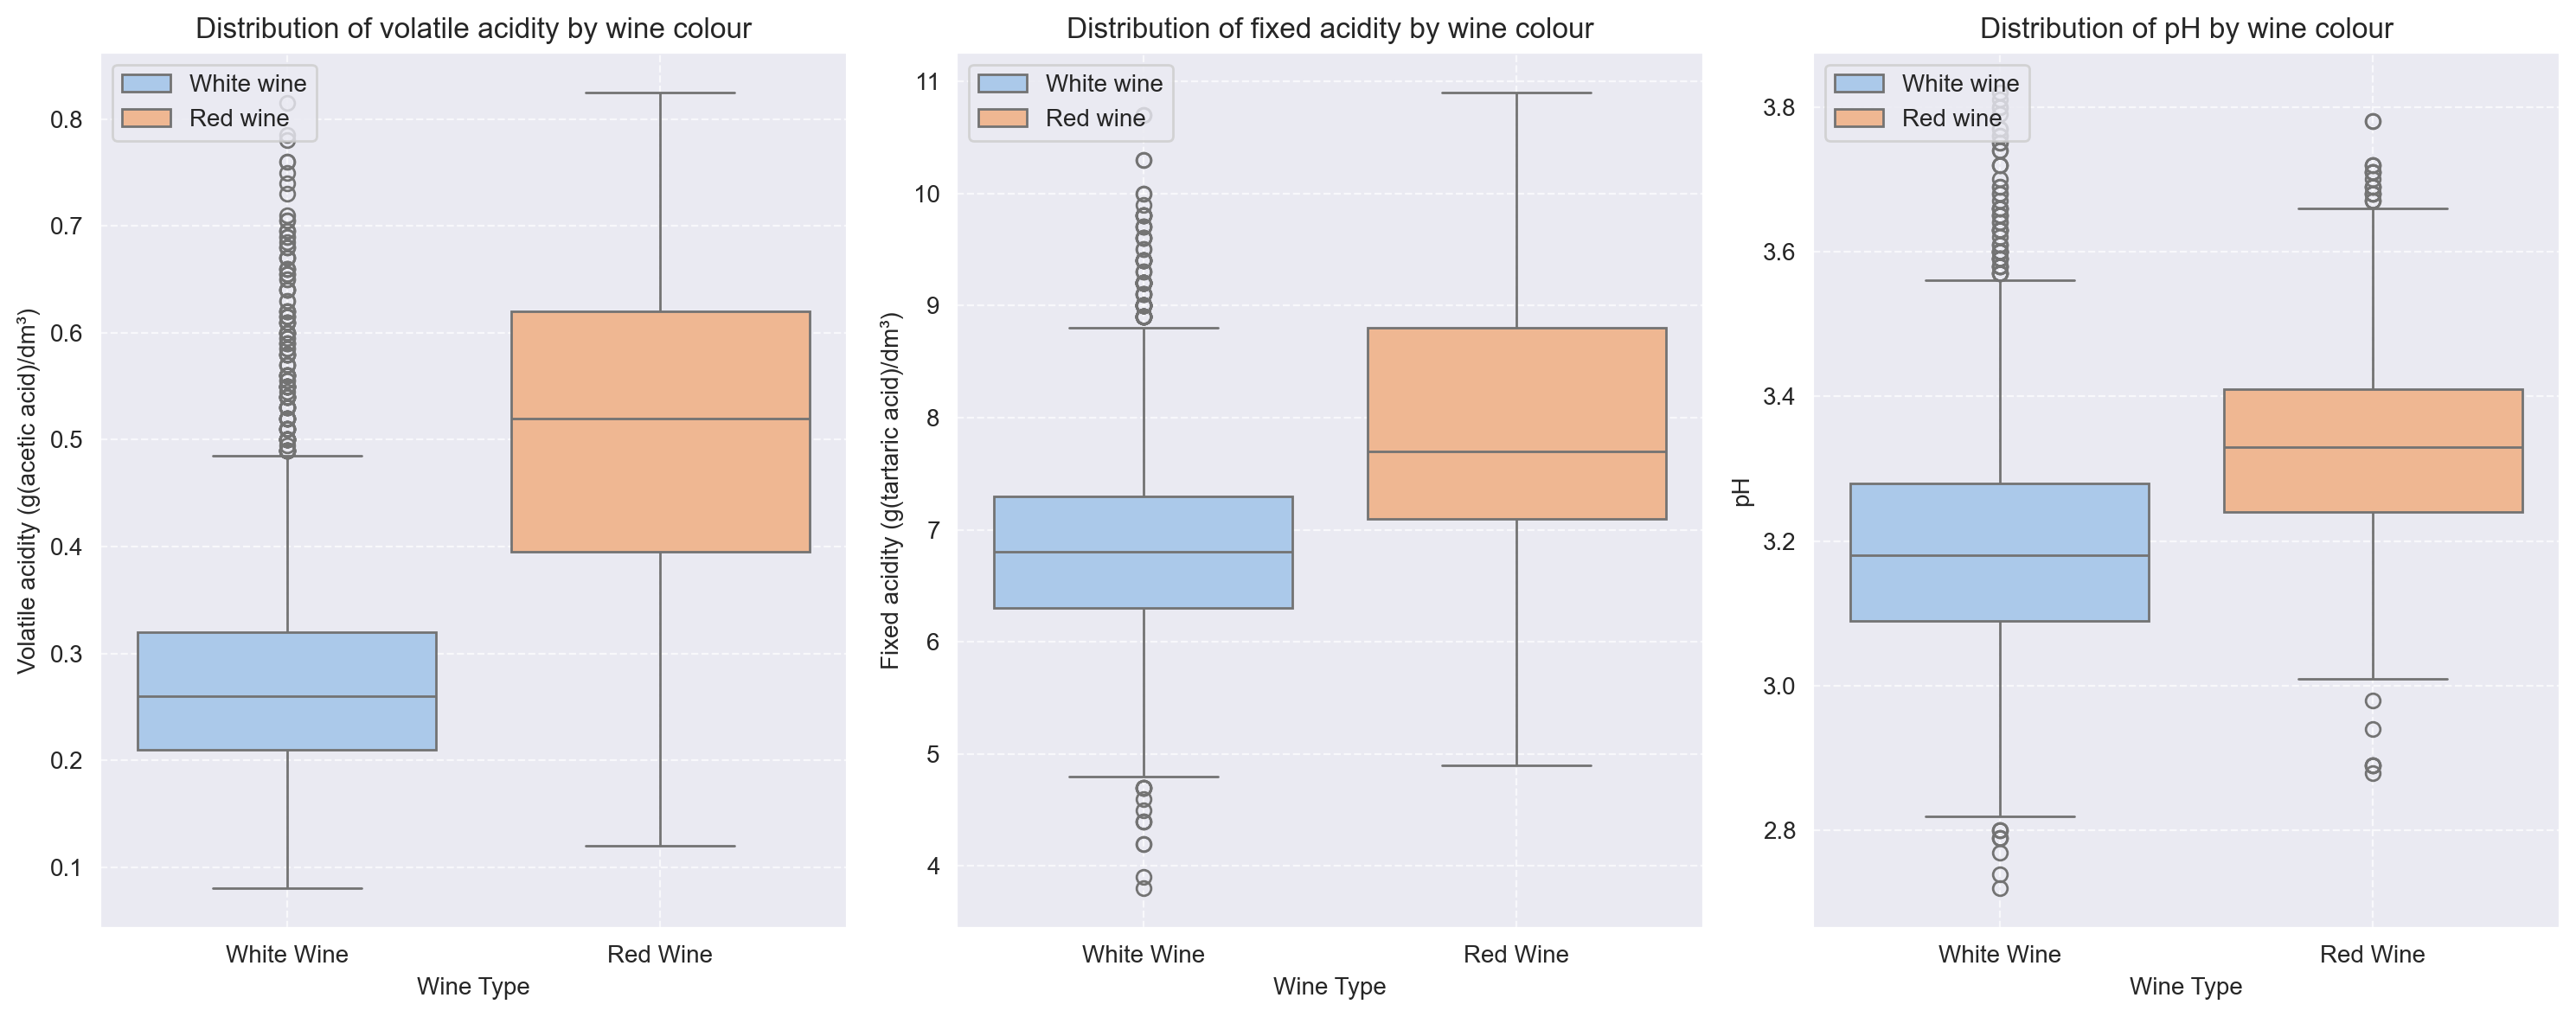

In [202]:
# Specify the order of variables
variables = ['volatile acidity', 'fixed acidity', 'pH']

# Create a 1x3 grid of box plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))  

# Iterate through each variable and create a box plot
for i, variable in enumerate(variables):
    ax = axes[i]
    sns.boxplot(x='colour', y=variable, data=outliers_removed_data, ax=ax,hue="colour")
    ax.set_title(f'Distribution of {variable} by wine colour')
    ax.set_xlabel('Wine Type')
    
    # Exclude units for pH
    if variable.lower() != 'ph':
        units = {
            'fixed acidity': 'g(tartaric acid)/dm³',
            'volatile acidity': 'g(acetic acid)/dm³',
        }
        ax.set_ylabel(f'{variable.capitalize()} ({units[variable]})')
    else:
        ax.set_ylabel(variable)
    legend = ax.legend(loc="upper left") 
    legend.get_texts()[0].set_text("White wine")
    legend.get_texts()[1].set_text("Red wine")
    # Customize x-axis labels
    ax.set_xticklabels(['White Wine', 'Red Wine'])

    # Show grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Save the figure
fig.savefig("final_box_plots_for_hotelling_two_sample.png", dpi=300, bbox_inches='tight')

In [203]:
from statsmodels.stats.multivariate import test_mvmean
# Sulfate content interesting due to fermentation - Does red have different levels of fermentation to white?
white_wine_sulfates = outliers_removed_data.loc[outliers_removed_data["colour"] == 0]
red_wine_sulfates = outliers_removed_data.loc[outliers_removed_data["colour"] == 1][["free sulfur dioxide","total sulfur dioxide","sulphates"]]
wine_wine_sulfates_means = white_wine_sulfates[["free sulfur dioxide","total sulfur dioxide","sulphates"]].mean()
one_sample_hotelling_test = test_mvmean(red_wine_sulfates,mean_null=wine_wine_sulfates_means)
print(one_sample_hotelling_test)
# One sample hotelling t test CI
display_cis(hotelling_t_test_ci(group_1=red_wine_sulfates, group_2=None))

statistic = 3682.534375706007
pvalue = 0.0
df = (3, 1271)
t2 = 11064.987239041102
distr = F
tuple = (3682.534375706007, 0.0)
free sulfur dioxide (-1011.28, 1043.90)
total sulfur dioxide (-3210.83, 3304.53)
sulphates (-11.16, 12.43)


C:\Users\kayvo\AppData\Local\Temp\ipykernel_35416\4249356302.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  white_wine_mean = wine_wine_sulfates_means[i]
C:\Users\kayvo\AppData\Local\Temp\ipykernel_35416\4249356302.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  white_wine_mean = wine_wine_sulfates_means[i]
C:\Users\kayvo\AppData\Local\Temp\ipykernel_35416\4249356302.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wh

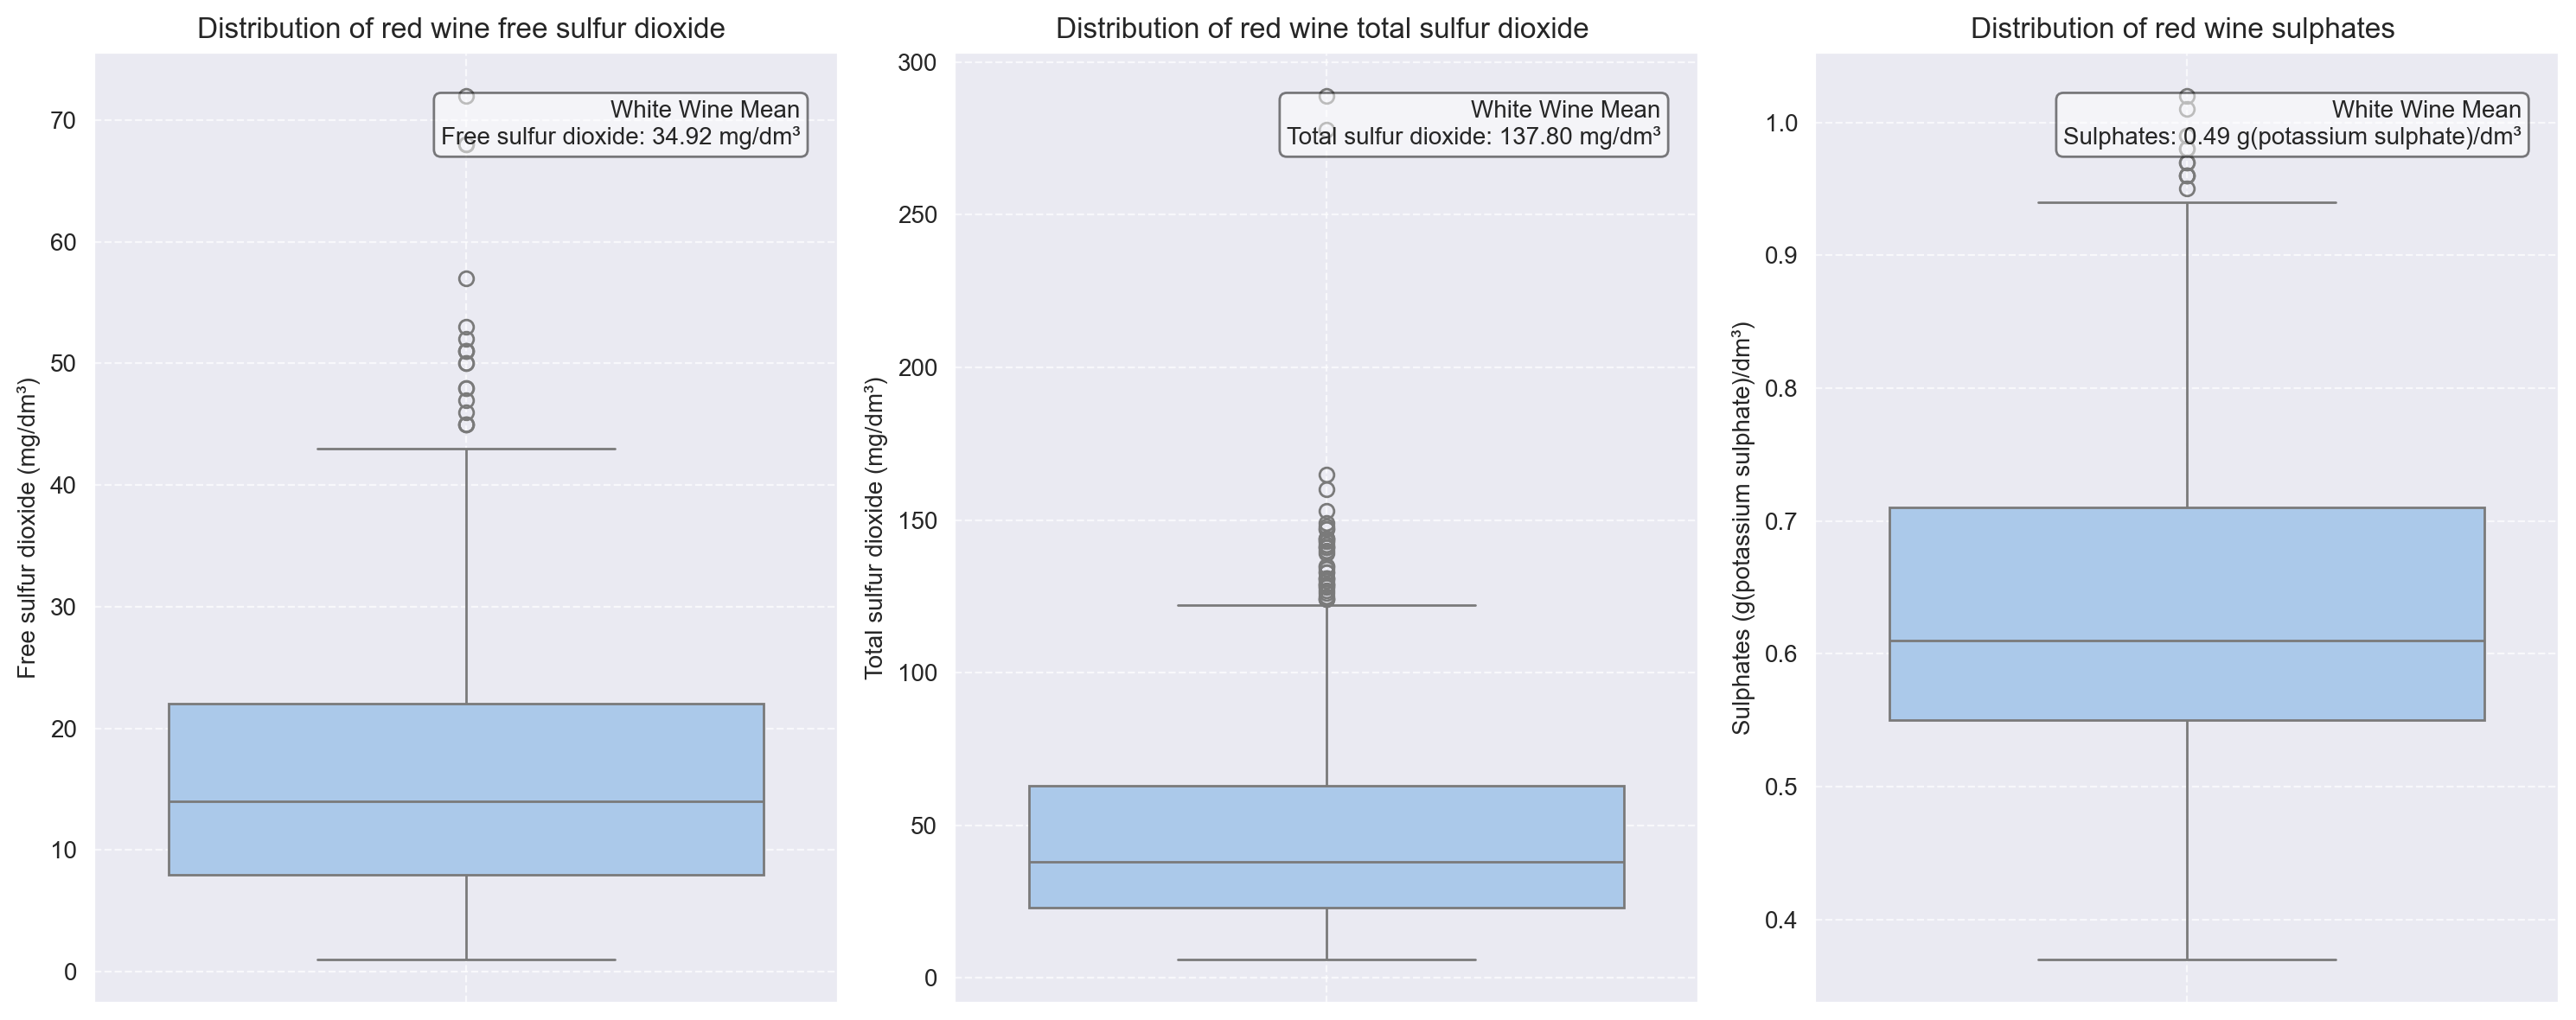

In [204]:
'''
In the report, I mentioned about a boxplot that I couldn't show due to space. Here is that plot. For reference: 
As a follow up analysis, we can produce boxplots to see which particular sulphate metric is the most different (Omitted due to space, but code available to generate them). From the boxplots, it seems most of the red wine total sulfur dioxide tends to have higher mean values than white wine, which could explain why the test result was statistically significant.
'''
variables = ["free sulfur dioxide","total sulfur dioxide","sulphates"]

# Create a 1x3 grid of box plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))  # Adjusted figsize for a wider plot

# Iterate through each variable and create a box plot
for i, variable in enumerate(variables):
    ax = axes[i]
    sns.boxplot(x=i, y=variable, data=red_wine_sulfates,  ax=ax)
    ax.set_title(f'Distribution of red wine {variable} ')
    
    # Add units to y-axis label
    units = {
        'free sulfur dioxide': 'mg/dm³',
        'total sulfur dioxide': 'mg/dm³',
        'sulphates': 'g(potassium sulphate)/dm³'
    }
    ax.set_ylabel(f'{variable.capitalize()} ({units[variable]})')
    
    # Customize x-axis labels
    ax.set_xticklabels("")
    
    # Add text annotation for white wine mean
    ax.grid(True, linestyle='--', alpha=0.7)
    white_wine_mean = wine_wine_sulfates_means[i]
    box_props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.annotate(f'White Wine Mean\n{variable.capitalize()}: {white_wine_mean:.2f} {units[variable]}', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', bbox=box_props)
    ax.annotate("", xy=(0.9, 0.9), xytext=(1, 1), xycoords='axes fraction', textcoords='axes fraction')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Save the figure
fig.savefig("final_box_plots_for_hotelling_one_sample.png", dpi=300, bbox_inches='tight')

In [205]:
# Below isn't used for my calculations but I thought I would include my implementation of hotelling t statistic in python with chi square test. Feel free to reach out to me if you would like some clarification on the code if you want to use it in future labs! You can do so if you mention it in your feedback, and I'll reach out to you after feedback has been released!

import scipy.stats
p_value_rejection_dictionary = {
    0.1 : "No evidence against H0",
    0.05 : "Weak evidence against H0",
    0.01 : "Some evidence against H0",
    0.001 : "Strong evidence against H0",
    0.0001 : "Very strong evidence against H0"
}
"""
An implementation for the box m test. Returns the p-value which can be used in assumption checking.
"""
def box_m_test(group_1: pd.DataFrame, group_2: pd.DataFrame) -> float:
    if group_1.shape[1] != group_2.shape[1]:
        raise ValueError(f"The number of dependent variables in group_1 ({group_1.shape[1]}) "
                         f"and group_2 ({group_2.shape[1]}) must be equal.")
    # Calculate group sizes
    group_1_n = group_1.shape[0]
    group_2_n = group_2.shape[0]
    # Can use either group 1 or 2 as they have equal number of variables - i.e. k value
    number_of_dependent_variables = group_1.shape[1]
    # Get the covariance matrix for both groups
    group_1_cov = group_1.cov()
    group_2_cov = group_2.cov()
    total_n = group_1_n + group_2_n
    # Calculated the pooled covariance matrix
    pooled_covariance_matrix = ((group_1_n - 1)*group_1_cov+(group_2_n-1)*group_2_cov)/(group_1_n+group_2_n-2)
    # 2 groups so m (lower case) is 2
    box_m_statistic = (total_n - 2)*np.log(np.linalg.det(pooled_covariance_matrix)) - (group_1_n*np.log(np.linalg.det(group_1_cov)) + group_2_n*np.log(np.linalg.det(group_2_cov)))
    # 2k^2 + 3k - 1 / 6(k+1)(m-1)
    critical_region_factor = (2*number_of_dependent_variables**2 + 3*number_of_dependent_variables - 1) / (6 * (number_of_dependent_variables + 1) * (2 - 1))
    # sum_{j=1}^m (where m = 2) 1/(n_j-1) - 1/(n-m), n being total_n
    critical_region_sum = 1/(group_1_n-1) - 1/(total_n-2) + 1/(group_2_n-1)
    # (2k^2 + 3k - 1 / 6(k+1)(m-1))*sum_{j=1}^m (where m = 2) 1/(n_j-1) - 1/(n-m), n being total_n
    critical_region = critical_region_factor*critical_region_sum
    # Calculate chi-square, df and p-value
    chi_square_statistic = box_m_statistic*(1-critical_region)
    df = 0.5*number_of_dependent_variables*(number_of_dependent_variables+1)*(2-1)
    p_value = scipy.stats.chi2.sf(chi_square_statistic,df)
    return p_value
'''
A function that takes in data from two groups and calculates the hotelling T-statistic for two groups for a given significance level. Checks for unequal covariances with box m test. Assumes it to be two sided and the data has been parsed in the correct format. Returns a string with the necessary information. Assumes large n for both groups. If significant, will return the confidence intervals
'''
def two_sided_hotelling_test(group_1 :  pd.DataFrame, group_2 :  pd.DataFrame, sig_level = 0.05) -> str:
    if group_1.shape[1] != group_2.shape[1]:
        raise ValueError(f"The number of dependent variables in group_1 ({group_1.shape[1]}) "
                         f"and group_2 ({group_2.shape[1]}) must be equal.")
    # Calculate group sizes
    group_1_n = group_1.shape[0]
    group_2_n = group_2.shape[0]
    # Can use either group 1 or 2 as they have equal number of variables
    number_of_dependent_variables = group_1.shape[1]
    # Calculate means for each variable for each group
    group_1_means = group_1.mean()
    group_2_means = group_2.mean()
    # Degrees of freedom for F statistic
    df1 = number_of_dependent_variables
    df2 = group_1_n + group_2_n - number_of_dependent_variables - 1
    # Find the difference between group 1 and 2 means
    vector_diff = group_1_means - group_2_means
    # Get the covariance matrix for both groups
    group_1_cov = group_1.cov()
    group_2_cov = group_2.cov()
    # Critical chi square 
    critical_chi_square = scipy.stats.chi2.ppf(sig_level,number_of_dependent_variables)
    # Check if we can assume equal covariances - if true used pooled
    box_m_test_result = box_m_test(group_1,group_2)
    if box_m_test_result <= 0.05:
        # (X-Y)^T * (V_x/n_x + V_y/n_y)^-1*(X-Y)
        hotelling_t_statistic = vector_diff@np.linalg.inv(group_1_cov/group_1_n+group_2_cov/group_2_n)@vector_diff.T
         # Assume n is sufficiently large. Assume equal number of dependent variables
        p_value = scipy.stats.chi2.sf(hotelling_t_statistic,number_of_dependent_variables)
        p_value_conclusion = "No evidence against H0"
        ci_dictionary = None
        if p_value < sig_level:
           ci_dictionary=hotelling_t_test_ci(group_1=group_1,group_2=group_2,sig_level=sig_level)
        for p_value_statement in p_value_rejection_dictionary.keys():
            if p_value < p_value_statement:
                p_value_conclusion = p_value_rejection_dictionary[p_value_statement]
        return f"""
        Hotelling T2 statistic: {hotelling_t_statistic}
        p_value: {p_value}
        Conclusion: {p_value_conclusion}
        Method: Unequal covariance approach
        Means with standard errors (None if not significant): {ci_dictionary}
        """       
    # Result was false, used alternative strategy    
    # Covariance for groups - used pooled if unbalanced
    covariance_matrix = None
    # Balanced group case
    if group_1_n == group_2_n:
        covariance_matrix = 0.5*(group_1.cov() + group_2.cov())
    else:
        covariance_matrix = ((group_1_n - 1)*group_1.cov()+(group_2_n-1)*group_2.cov())/(group_1_n+group_2_n-2)
    # Find mahalanobis distance and hotelling T statistic
    mahalanobis_distance_squared = vector_diff@np.linalg.inv(covariance_matrix)@vector_diff.T
    hotelling_t_statistic = (group_1_n*group_2_n)/(group_1_n+group_2_n) * mahalanobis_distance_squared
    # Assume n is sufficiently large. Assume equal number of dependent variables
    p_value = scipy.stats.chi2.sf(hotelling_t_statistic,number_of_dependent_variables)
    p_value_conclusion = "No evidence against H0"
    ci_dictionary = None
    if p_value < sig_level:
       ci_dictionary=hotelling_t_test_ci(group_1=group_1,group_2=group_2,sig_level=sig_level)
    for p_value_statement in p_value_rejection_dictionary.keys():
        if p_value < p_value_statement:
            p_value_conclusion = p_value_rejection_dictionary[p_value_statement]
    return f"""
    Hotelling T2 statistic: {hotelling_t_statistic}
    p_value: {p_value}
    Conclusion: {p_value_conclusion}
    Method: Equal covariance approach
    Means with standard errors (None if not significant): {ci_dictionary}
    """      



In [206]:
# Again, not used in final report at all but still wanted to include it as code isn't assessed
# Here's a version of 2 sample hotelling but with an F-statistic. I've confirmed it works :)
'''
A function that takes in data from two groups and calculates the hotelling T-statistic for two groups for a given significance level. Assumes it to be two sided and the data has been parsed in the correct format. Returns a string with the necessary information.
'''
def two_sided_hotelling_test_f_statistic_version(group_1: pd.DataFrame, group_2: pd.DataFrame) -> str:
    if group_1.shape[1] != group_2.shape[1]:
        raise ValueError(f"The number of dependent variables in group_1 ({group_1.shape[1]}) "
                         f"and group_2 ({group_2.shape[1]}) must be equal.")

    # Calculate group sizes
    group_1_n = group_1.shape[0]
    group_2_n = group_2.shape[0]

    # Can use either group 1 or 2 as they have an equal number of variables
    number_of_dependent_variables = group_1.shape[1]

    # Calculate means for each variable for each group
    group_1_means = group_1.mean()
    group_2_means = group_2.mean()

    # Degrees of freedom for F statistic
    df1 = number_of_dependent_variables
    df2 = group_1_n + group_2_n - number_of_dependent_variables - 1

    # Covariance for groups - used pooled if unbalanced
    covariance_matrix = None

    # Balanced group case
    if group_1_n == group_2_n:
        covariance_matrix = 0.5 * (group_1.cov() + group_2.cov())
    else:
        covariance_matrix = ((group_1_n - 1) * group_1.cov() + (group_2_n - 1) * group_2.cov()) / (group_1_n + group_2_n - 2)

    # Find the difference between group 1 and 2 means
    vector_diff = group_1_means - group_2_means

    # Find mahalanobis distance and hotelling T statistic
    mahalanobis_distance_squared = vector_diff @ np.linalg.inv(covariance_matrix) @ vector_diff.T
    hotelling_t_statistic = (group_1_n * group_2_n) / (group_1_n + group_2_n) * mahalanobis_distance_squared

    # Get F statistic and p-value. Assumes an equal number of dependent variables
    f_statistic = (group_1_n + group_2_n - number_of_dependent_variables - 1) / (number_of_dependent_variables * (group_1_n + group_2_n - 2)) * hotelling_t_statistic
    p_value = 1 - scipy.stats.f.cdf(f_statistic, df1, df2)

    p_value_conclusion = "No evidence against H0"

    for p_value_statement in p_value_rejection_dictionary.keys():
        if p_value < p_value_statement:
            p_value_conclusion = p_value_rejection_dictionary[p_value_statement]

    return f"""
    Hotelling T2 statistic: {hotelling_t_statistic}
    F-statistic: {f_statistic}
    p_value: {p_value}
    Conclusion: {p_value_conclusion}
    """
